In [ ]:
!nvidia-smi

Sat Sep 18 00:44:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 9383, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 9383 (delta 19), reused 26 (delta 13), pack-reused 9338
Receiving objects: 100% (9383/9383), 9.81 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (6509/6509), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 636 kB 10.5 MB/s 
Setup complete. Using torch 1.9.0+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


In [ ]:
%cd /content
!curl -L "https://app.roboflow.com/ds/F6wwsLVypC?key=QSe68kWj44" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   896  100   896    0     0   1372      0 --:--:-- --:--:-- --:--:--  1372
100 3437k  100 3437k    0     0  2480k      0  0:00:01  0:00:01 --:--:-- 6523k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab-3003_JPG.rf.ca170d33f798ef882b7b01b297644c12.jpg  
 extracting: test/images/0a41c25a-f9a6-4c34-8e5c-7f89a6ac4c40___FREC_C-Rust-9807_JPG.rf.18427c65cd026eded5ed451653b20747.jpg  
 extracting: test/images/0afaaf78-6ec5-49ee-a070-f6217039ed2d___RS_HL-7827_JPG.rf.f2bfdaa087b2b71370eb8831e4c15009.jpg  
 extracting: test/images/0b00a1a8-b525-4392-bb6c-3ffb7d824bee___RS_HL-7904_JPG.rf.c6f86f1cba9a5467939f79d869f802c6.jpg  

In [ ]:
%cat data.yaml

train: ../train/images
val: ../valid/images

nc: 4
names: ['Cedar Apple Rust', 'black rot', 'healthy', 'scab']

In [ ]:
import yaml
with open("data.yaml", 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
      f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml
# parametersnc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
# anchors
anchors:
- [10,13, 16,30, 33,23] # P3/8
- [30,61, 62,45, 59,119] # P4/16
- [116,90, 156,198, 373,326] # P5/32
# YOLOv5 backbone
backbone:
# [from, number, module, args]
[[-1, 1, Focus, [64, 3]], # 0-P1/2
[-1, 1, Conv, [128, 3, 2]], # 1-P2/4
[-1, 3, BottleneckCSP, [128]],
[-1, 1, Conv, [256, 3, 2]], # 3-P3/8
[-1, 9, BottleneckCSP, [256]],
[-1, 1, Conv, [512, 3, 2]], # 5-P4/16
[-1, 9, BottleneckCSP, [512]],
[-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
[-1, 1, SPP, [1024, [5, 9, 13]]],
[-1, 3, BottleneckCSP, [1024, False]], # 9
]
# YOLOv5 head
head:
[[-1, 1, Conv, [512, 1, 1]],
[-1, 1, nn.Upsample, [None, 2, 'nearest']],
[[-1, 6], 1, Concat, [1]], # cat backbone P4
[-1, 3, BottleneckCSP, [512, False]], # 13
[-1, 1, Conv, [256, 1, 1]],
[-1, 1, nn.Upsample, [None, 2, 'nearest']],
[[-1, 4], 1, Concat, [1]], # cat backbone P3
[-1, 3, BottleneckCSP, [256, False]], # 17 (P3/8-small)
[-1, 1, Conv, [256, 3, 2]],
[[-1, 14], 1, Concat, [1]], # cat head P4
[-1, 3, BottleneckCSP, [512, False]], # 20 (P4/16-medium)
[-1, 1, Conv, [512, 3, 2]],
[[-1, 10], 1, Concat, [1]], # cat head P5
[-1, 3, BottleneckCSP, [1024, False]], # 23 (P5/32-large)
[[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
]

Rename folder test ke valid dulu

In [ ]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data '../data.yaml' --cfg ./models/yolov5s.yaml --weights '../yolov5s.pt' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 514 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/yolov5s.yaml', data='../data.yaml', device='', entity=None, epochs=100, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results3', single_cls=False, sync_bn=False, total_batch_size=16, weights='../yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorbo

In [ ]:
%cd /content/yolov5/
!python test.py --img 416 --batch 16 --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --data /content/data.yaml

/content/yolov5
Namespace(augment=False, batch_size=16, conf_thres=0.001, data='/content/data.yaml', device='', exist_ok=False, img_size=416, iou_thres=0.6, name='exp', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
val: Scanning '../valid/labels.cache' for images and

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/healthy.jpg

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/healthy.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
image 1/1 /content/healthy.jpg: 256x256 1 healthy, Done. (0.021s)
Results saved 

Kita bisa melihat bahwa hasil disimpat pada Results saved to runs/detect/exp5

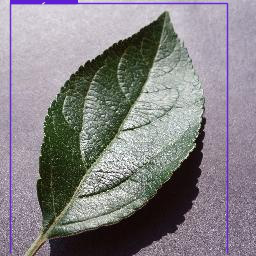

In [ ]:
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp5/healthy.jpg')

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/scab1.jpg

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/scab1.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
image 1/1 /content/scab1.jpg: 256x256 1 black rot, Done. (0.020s)
Results saved to

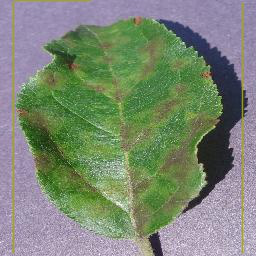

In [ ]:
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp16/scab1.jpg')

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/black_rot.jpg

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/black_rot.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
image 1/1 /content/black_rot.jpg: 256x256 1 black rot, Done. (0.020s)
Results 

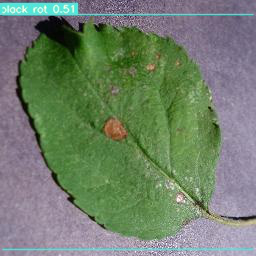

In [ ]:
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp13/black_rot.jpg')

In [ ]:
%cd /content/yolov5/
!python detect.py --weights /content/yolov5/runs/train/yolov5s_results3/weights/best.pt --img-size 256 --iou-thres 0.1 --conf 0.1 --source /content/Cedar_Apple_Rust.jpg

/content/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.1, device='', exist_ok=False, img_size=256, iou_thres=0.1, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/Cedar_Apple_Rust.jpg', update=False, view_img=False, weights=['/content/yolov5/runs/train/yolov5s_results3/weights/best.pt'])
YOLOv5 v4.0-126-g886f1c0 torch 1.9.0+cu102 CUDA:0 (Tesla K80, 11441.1875MB)

Fusing layers... 
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7062001 parameters, 0 gradients, 16.4 GFLOPS
image 1/1 /content/Cedar_Apple_Rust.jpg: 256x256 1 Cedar Apple Rust, Do

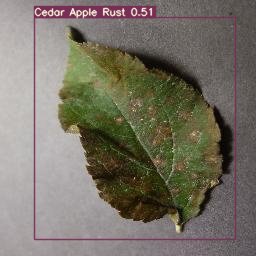

In [ ]:
from keras.preprocessing import image
image.load_img('/content/yolov5/runs/detect/exp9/Cedar_Apple_Rust.jpg')

## Kesimpulan

Dalam CNN ini kita melakukan plan health classification dengan model yolov5s sebagai transfer learning model CNN. Kita Klasifikasi Apple healthy, black rot, scap, dan Cedar_Apple_Rust mendapatkan hasil

+ Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 3/3 [00:01<00:00,  2.06it/s]
+                  all          36          36        0.81       0.981        0.95       0.765
+     Cedar Apple Rust          36          11           1        0.98       0.995       0.792
+           black rot          36           7       0.622           1       0.924       0.784
+             healthy          36           8       0.715       0.946       0.915        0.71
+                scab          36          10       0.903           1       0.968       0.772


dengan Presisi sebesar 0.81, Recall sebesar 0.981, mAP 50% sebesar 0.95, dan mAP untuk 50% sampai 95% sebesar 0.765. Model ini dapat dikatakan cukup bagus.

## Jawaban di Akhir Video

Terdapat 2 garis IoU dalam output yang mengartikan bahwa dalam pelebelan Anotasi dilakukan 2 anotasi atau dilakukan multi class pelabelan sehingga terdapat output yang memiliki 2 garis IoU karena mengandung kotak prediksi yang mendekati garis anotasi dari yang telah kita lakukan.